In [1]:
import numpy as np
from scipy import io
from os import listdir
import os
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

import time
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm

### helper functions
from dataset_loader import SPD_dataset
from spdnet_init_afew_dep import spdnet_init_afew
from spdnet.utils.load_data import load_data
from accumulate_gradients import accumulate_gradients
from spdnet.vl_folder.vl_myforbackward import vl_myforbackward

In [2]:
lab = '/Users/annakuzina/Google Drive/study/masters/research/working stuff/depression/data/targets_final.csv'
data_dir = '/Users/annakuzina/Google Drive/study/masters/research/working stuff/depression/data/clean_last/'


# Additional functions

In [3]:
def iterate_minibathces(X, y, batchsize):
    """
    X = 3-dim tensor (data_size, rows=118, cols=118)
    """
    indices = np.random.permutation(np.arange(X.shape[0]))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [4]:
def calculate_error(true_labels, predictions, print_result = False):
    
    ind = np.argsort(-predictions, axis = 1)[:, 0]
    answer = np.sum(ind != true_labels-1)
    
    if print_result:
        print("true_labels", true_labels)
        u, indices = np.unique(true_labels, return_counts=True)
        print("Must_have", u[np.argmax(indices)])
        print("ind", ind)
    
    return answer / predictions.shape[0]

# Training

# D no D

In [12]:
opts = {}

opts['batchSize'] = 45
opts['test_batchSize'] = 1
opts['numEpochs'] = 800
opts['learningRate'] = 0.05 * np.ones(opts['numEpochs'])
opts['weightDecay'] = 0.01
opts['continue'] = 1

In [13]:
data_loader = SPD_dataset(threshold = 0.3, labels_dir = lab, data_dir = data_dir)
X, y, l = data_loader.create_dataset('D/no D')
y_enc = np.array(y)
y_enc[np.array(y) == l] = 1
y_enc[np.array(y) != l] = 2
# X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size = 0.1, stratify = y)

/Users/annakuzina/Google Drive/study/masters/Research/Working stuff/depression/SPDNet/dataset_loader.py:31: RuntimeWarning: invalid value encountered in greater
  binary_matrix = (abs(X) > self.threshold).astype(int)


In [9]:
def train(X_train, y_train, X_val, y_val):
    num_epochs = opts['numEpochs']

    net = spdnet_init_afew(12336)

    train_error = []
    val_error = []

    train_loss = []
    val_loss = []


    for epoch in range(opts['numEpochs']):

        start_time = time.time()

        train_error_per_epoch = []
        val_error_per_epoch = []

        train_loss_per_epoch = []
        val_loss_per_epoch = []

        zz = 0

        # training mode
        net['train_mode'] = True

        for X_batch, y_batch in iterate_minibathces(X_train, y_train, opts['batchSize']):
            print('batch num: ', zz + 1)

            net['layers'][-1]['class'] = y_batch
            res = vl_myforbackward(net=net, x=X_batch, dzdy=1, res=None, varargin=None)
            [net, res] = accumulate_gradients(opts=None, lr=opts['learningRate'][epoch], 
                                              batchSize=X_batch.shape[0], net=net, res=res)
            predictions = res['x'][-2]

            train_error_per_epoch.append(calculate_error(y_batch, predictions))
            train_loss_per_epoch.append(res['x'][-1])

            zz += 1


        train_error.append(np.mean(train_error_per_epoch))
        train_loss.append(np.mean(train_loss_per_epoch))


        # test mode
        net['train_mode'] = False

        for X_batch, y_batch in iterate_minibathces(X_val, y_val, opts['batchSize']):
            net['layers'][-1]['class'] = y_batch
            res = vl_myforbackward(net=net, x=X_batch, dzdy=None, res=None)

            predictions = res['x'][-2]

            val_error_per_epoch.append(calculate_error(y_batch, predictions))
            val_loss_per_epoch.append(res['x'][-1])


        val_error.append(np.mean(val_error_per_epoch))
        val_loss.append(np.mean(val_loss_per_epoch))

        # Visualize and print the results

        display.clear_output(wait=True)

        # Visualize

        fig = plt.figure(figsize=(20, 8))
        plot1 = fig.add_subplot(121)
        plot2 = fig.add_subplot(122)


        plot1.set_title("Error on training and validation", size = 20)
        plot1.set_xlabel("number of epoch", size = 20)
        plot1.set_ylabel("Error", size = 20)
        plot1.plot(train_error, 'b', label="Training error")
        plot1.plot(val_error, 'g', label="Validation error")

        plot1.legend()


        plot2.set_title("Loss on training and validation", size = 20)
        plot2.set_xlabel("number of epoch", size = 20)
        plot2.set_ylabel("Loss", size = 20)
        plot2.plot(train_loss, 'b', label="Training loss")
        plot2.plot(val_loss, 'g', label="Validation loss")

        plot2.legend()

        plt.show()

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training error: \t{:.6f}".format(
            np.mean(train_error[-1])))
        print("  validation error: \t{:.6f} ".format(
            np.mean(val_error[-1])))

        print("  training loss: \t{:.6f}".format(
            np.mean(train_loss[-1])))
        print("  validation loss: \t{:.6f} ".format(
            np.mean(val_loss[-1])))

    del net
    return train_loss, val_loss, train_error, val_error

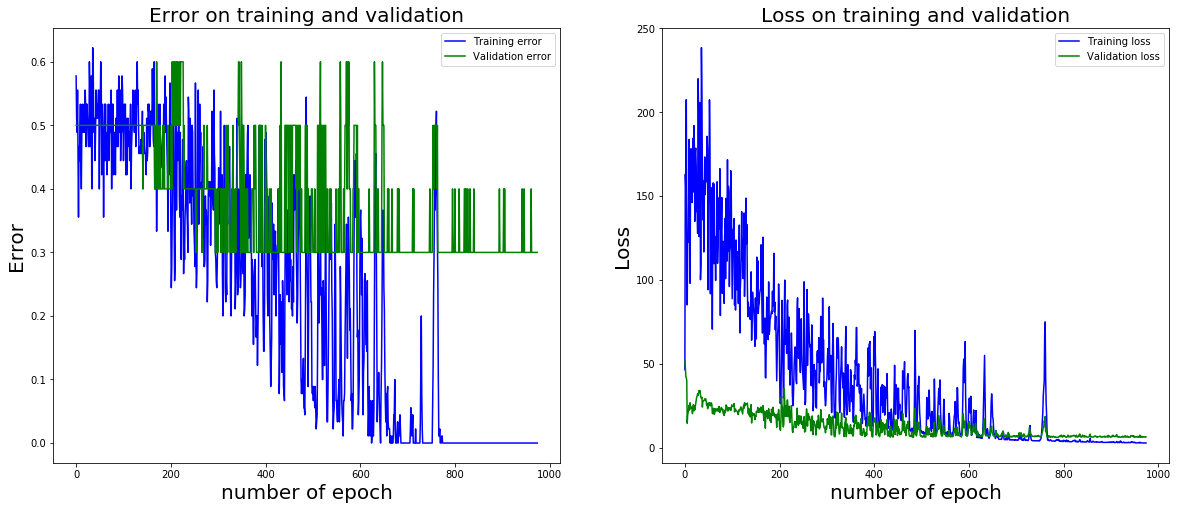

Epoch 975 of 1000 took 1.413s
  training error: 	0.000000
  validation error: 	0.300000 
  training loss: 	2.992888
  validation loss: 	6.561048 
batch num:  1
batch num:  2


KeyboardInterrupt: 

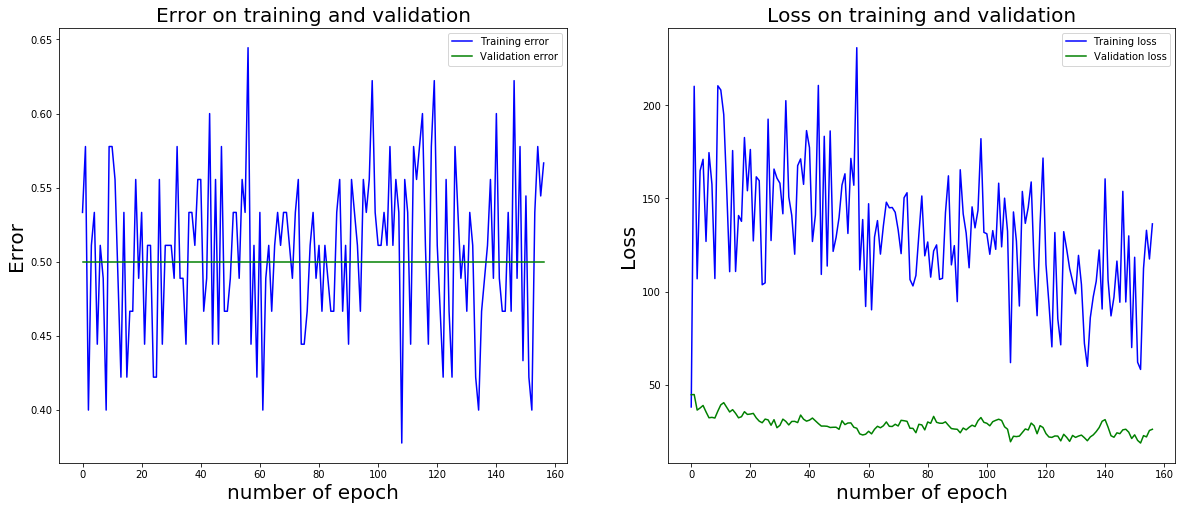

Epoch 157 of 800 took 1.470s
  training error: 	0.566667
  validation error: 	0.500000 
  training loss: 	136.352785
  validation loss: 	26.117382 
batch num:  1
batch num:  2


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
random_state = 42
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
i = 0
loss = []
acc = []
i = 1
for tr, tst in cv.split(X, y_enc):
#     print(X[train], X[test], y_enc[train], y_enc[test])
    print('Training {}'.format(i))
    train_loss, val_loss, train_error, val_error = train(X[tr], y_enc[tr], X[tst], y_enc[tst])
    loss.append(val_loss[-1])
    acc.append(1 - val_error[-1])
    i += 1

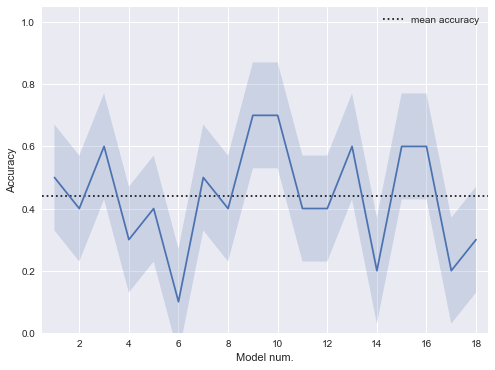

In [55]:
import seaborn as sns; sns.set(color_codes=True)
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(range(1,len(acc)+1), acc)
ax.hlines(np.array(acc).mean(), 0.5,len(acc)+0.5, linestyles ='dotted', label='mean accuracy')
ax.fill_between(range(1,len(acc)+1), np.array(acc)-np.array(acc).std(), np.array(acc)+np.array(acc).std(), alpha = 0.2)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model num.')
ax.set_ybound(0,1.05)
ax.set_xbound(0.5,len(acc)+0.5)
ax.legend()
fig.savefig('Rnet_dep.png')

In [15]:
print(np.array(acc).mean())
print(np.array(acc).std())

0.4388888888888889
0.1704206850019774


In [33]:
len(acc)

18

# E no E

In [24]:
data_loader = SPD_dataset(threshold = 0.2, labels_dir = lab, data_dir = data_dir)
X, y, l = data_loader.create_dataset('E/no E')
y_enc = np.array(y)
y_enc[np.array(y) == l] = 1
y_enc[np.array(y) != l] = 2
# X_train, X_val, y_train, y_val = train_test_split(X, y_enc, test_size = 0.1, stratify = y)

/Users/annakuzina/Google Drive/study/masters/Research/Working stuff/depression/SPDNet/dataset_loader.py:31: RuntimeWarning: invalid value encountered in greater
  binary_matrix = (abs(X) > self.threshold).astype(int)


In [22]:
opts = {}

opts['batchSize'] = 45
opts['test_batchSize'] = 1
opts['numEpochs'] = 800
opts['learningRate'] = 0.05 * np.ones(opts['numEpochs'])
opts['weightDecay'] = 0.01
opts['continue'] = 1

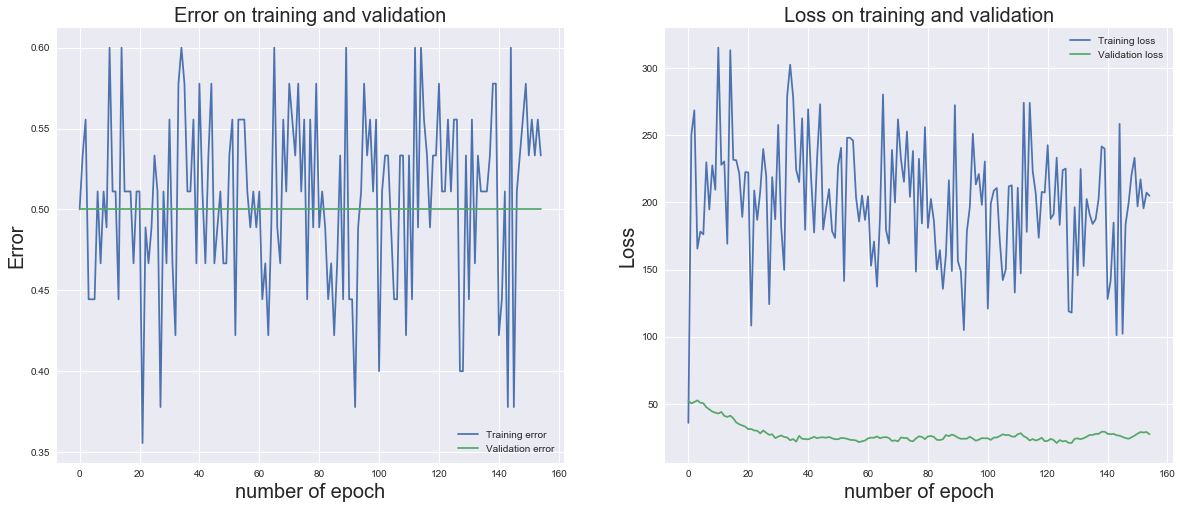

Epoch 155 of 800 took 1.498s
  training error: 	0.533333
  validation error: 	0.500000 
  training loss: 	204.852052
  validation loss: 	27.366878 
batch num:  1


In [ ]:
random_state = 42
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
i = 0
loss_e = []
acc_e = []
i = 1
for tr, tst in cv.split(X, y_enc):
    print('Training {}'.format(i))
    train_loss, val_loss, train_error, val_error = train(X[tr], y_enc[tr], X[tst], y_enc[tst])
    loss_e.append(val_loss[-1])
    acc_e.append(1 - val_error[-1])
    i += 1

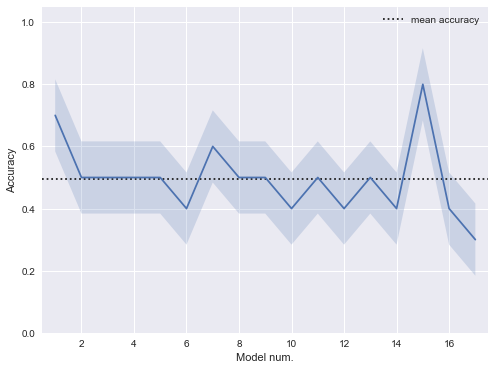

In [54]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(range(1,len(acc_e)+1), acc_e)
ax.hlines(np.array(acc_e).mean(), 0.5,len(acc)+0.5, linestyles ='dotted', label='mean accuracy')
ax.fill_between(range(1,len(acc_e)+1), np.array(acc_e)-np.array(acc_e).std(), np.array(acc_e)+np.array(acc_e).std(), alpha = 0.2)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model num.')
ax.set_ybound(0,1.05)
ax.set_xbound(0.5,len(acc_e)+0.5)
fig.savefig('Rnet_ep.png')
ax.legend()

In [32]:
np.array(acc_e).mean()
np.array(acc_e).std()

0.11616716269489116

# DE E

In [ ]:
opts = {}

opts['batchSize'] = 5
opts['test_batchSize'] = 1
opts['numEpochs'] = 500
opts['learningRate'] = 0.09 * np.ones(opts['numEpochs'])
opts['weightDecay'] = 0.001
opts['continue'] = 1


In [ ]:
data_loader = SPD_dataset(threshold = 0.3, labels_dir = lab, data_dir = data_dir)
X, y, l = data_loader.create_dataset('DE/E')
y_enc = np.array(y)
y_enc[y == l] = int(1)
y_enc[y != l] = int(0)
X_train, X_val, y_train, y_val = train_test_split(X, y_enc.astype(int), test_size = 0.1, stratify = y)

In [ ]:
num_epochs = opts['numEpochs']

net = spdnet_init_afew(12336)

train_error = []
val_error = []

train_loss = []
val_loss = []


for epoch in range(opts['numEpochs']):

    start_time = time.time()

    train_error_per_epoch = []
    val_error_per_epoch = []

    train_loss_per_epoch = []
    val_loss_per_epoch = []

    zz = 0

    # training mode
    net['train_mode'] = True

    for X_batch, y_batch in iterate_minibathces(X_train, y_train, opts['batchSize']):
        print('batch num: ', zz + 1)

        net['layers'][-1]['class'] = y_batch
        res = vl_myforbackward(net=net, x=X_batch, dzdy=1, res=None, varargin=None)
        [net, res] = accumulate_gradients(opts=None, lr=opts['learningRate'][epoch], 
                                          batchSize=X_batch.shape[0], net=net, res=res)
        predictions = res['x'][-2]

        train_error_per_epoch.append(calculate_error(y_batch, predictions))
        train_loss_per_epoch.append(res['x'][-1])

        zz += 1


    train_error.append(np.mean(train_error_per_epoch))
    train_loss.append(np.mean(train_loss_per_epoch))


    # test mode
    net['train_mode'] = False

    for X_batch, y_batch in iterate_minibathces(X_val, y_val, opts['batchSize']):
        net['layers'][-1]['class'] = y_batch
        res = vl_myforbackward(net=net, x=X_batch, dzdy=None, res=None)

        predictions = res['x'][-2]

        val_error_per_epoch.append(calculate_error(y_batch, predictions))
        val_loss_per_epoch.append(res['x'][-1])


    val_error.append(np.mean(val_error_per_epoch))
    val_loss.append(np.mean(val_loss_per_epoch))

    # Visualize and print the results

    display.clear_output(wait=True)

    # Visualize

    fig = plt.figure(figsize=(20, 8))
    plot1 = fig.add_subplot(121)
    plot2 = fig.add_subplot(122)


    plot1.set_title("Error on training and validation", size = 20)
    plot1.set_xlabel("number of epoch", size = 20)
    plot1.set_ylabel("Error", size = 20)
    plot1.plot(train_error, 'b', label="Training error")
    plot1.plot(val_error, 'g', label="Validation error")

    plot1.legend()


    plot2.set_title("Loss on training and validation", size = 20)
    plot2.set_xlabel("number of epoch", size = 20)
    plot2.set_ylabel("Loss", size = 20)
    plot2.plot(train_loss, 'b', label="Training loss")
    plot2.plot(val_loss, 'g', label="Validation loss")

    plot2.legend()

    plt.show()

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training error: \t{:.6f}".format(
        np.mean(train_error[-1])))
    print("  validation error: \t{:.6f} ".format(
        np.mean(val_error[-1])))

    print("  training loss: \t{:.6f}".format(
        np.mean(train_loss[-1])))
    print("  validation loss: \t{:.6f} ".format(
        np.mean(val_loss[-1])))
